In [17]:
import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path


import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 2


In [19]:
names = []
images = []
image_size = (3, 128, 128)
fill_color = (255, 255, 255)

for img in os.listdir('./pokemon/images/images'):
    im = Image.open('./pokemon/images/images/{}'.format(img))
    names.append(img.split('.')[0])
    im = im.convert("RGBA")
    if im.mode in ('RGBA', 'LA'):
        bg = Image.new(im.mode[:-1], image_size[1:], fill_color) # size = (128, 128, 3)
        bg.paste(im, im.split()[-1])
        im = bg

    images.append(np.asarray(im))
images = (np.asarray(images).astype(np.float32) / 255.0)

In [20]:
batch_size = 16
use_cuda = True

class Pokeman(Dataset):
    def __init__(self, imgs, names):
        self.data = imgs
        self.label = names
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx], idx
    
train_set = Pokeman(images[:-9], names[:-9])

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, 
    shuffle=True, num_workers=8, pin_memory=False,
)

val_loader = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=8*8)

loaders = {
    'train' : train_loader,
    'val'  : val_loader,
}

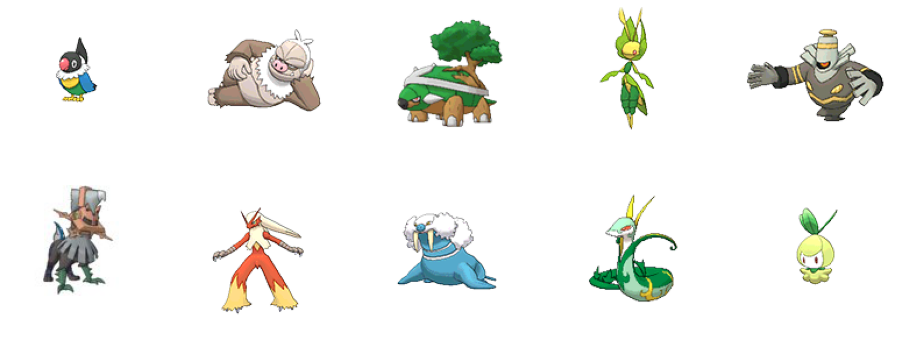

In [21]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _, _ = train_loader.dataset.__getitem__(i)
    to_plot = image.numpy().transpose((1, 2, 0)) / 2 + 0.5
    plt.imshow(to_plot)
    plt.axis('off');

In [22]:
def project_l2_ball(z):
    """ project vectors in z onto the l2 unit norm ball"""
    return z / np.maximum(np.sqrt(np.sum(z**2, axis=1))[:, np.newaxis], 1)

def imsave(filename, array):
    im = Image.fromarray((array * 255).astype(np.uint8))
    im.save(filename)

In [23]:
# DCGAN architecture
code_dim = 128
class Decoder(nn.Module):
    def __init__(self, code_dim, n_filter=64, out_channels=3):
        super(Decoder, self).__init__()
        self.code_dim = code_dim
        nf = n_filter
        self.dcnn = nn.Sequential(
            nn.ConvTranspose2d(code_dim, nf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf * 16), 
            nn.ReLU(True), # 512 * 4 * 4
            nn.ConvTranspose2d(nf * 16, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),   
            nn.ReLU(True), # 256 * 8 * 8
            nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(nf * 4), 
            nn.ReLU(True), # 128 * 16 * 16
            nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2), 
            nn.ReLU(True), # 64 * 32 * 32
            nn.ConvTranspose2d(nf * 2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf), 
            nn.ReLU(True), # 32 * 64 * 64
            nn.ConvTranspose2d(nf, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 3 * 128 * 128
        )

    def forward(self, code):
        return self.dcnn(code.view(code.size(0), self.code_dim, 1, 1))
    


In [24]:
class LatentVariables(nn.Module):
    def __init__(self, Z):
        super(LatentVariables, self).__init__()
        self.Z = Parameter(Z)

    def forward(self, indices):
        return self.Z[indices]

In [25]:
Z = np.random.normal(size=(len(train_set), 1, code_dim)).astype(np.float32) # (800, 128)
Z = torch.tensor(project_l2_ball(Z), requires_grad=True).to(device)
Z.shape

torch.Size([800, 1, 128])

In [26]:
class CombinedModel(nn.Module):
    def __init__(self, Z, code_dim, n_filters=64):
        super(CombinedModel, self).__init__()
        self.Z = LatentVariables(Z)
        self.Decoder = Decoder(code_dim)

    def forward(self, index):
        code = self.Z(index)
        return self.Decoder(code)

In [27]:
def maybe_cuda(tensor):
    return tensor.cuda() if use_cuda else tensor

g = CombinedModel(Z, code_dim).to(device)
print(g)

CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64, 

In [28]:
def weight_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv')!=-1:
        module.weight.data.normal_(0.0, .02)
    elif classname.find('BatchNorm') != -1:
        module.weight.data.normal_(1.0, .01)
        module.bias.data.fill_(0.0)

g.apply(weight_init)

CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64, 

In [29]:
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_val, _, idx_val = next(iter(val_loader)) # Xi_val: [64, 3, 128, 128]
imsave('target.png', make_grid(Xi_val.cpu() / 2. + 0.5, nrow=8).numpy().transpose(1, 2, 0))

In [30]:
import shutil

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)
        
def load_ckp(checkpoint_fpath, model_to_load, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model_to_load.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model_to_load, optimizer, checkpoint['epoch']

In [31]:
def train_and_save(start_epoch, n_epochs, loaders, g, optimizer, checkpoint_path, best_model_path):
    g.train()
    
    for epoch in range(start_epoch, n_epochs+1):
        losses = []
        progress = tqdm(total=len(loaders['train']), desc='epoch % 3d' % epoch)
        
        for i, (Xi, _, idx) in enumerate(loaders['train']):
    
            Xi = Variable(Xi.to(device))

            G_zi = g(idx.numpy())
            loss = loss_fn(G_zi, Xi)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             y = Z[idx.numpy()].clone()
            Z[idx.numpy()] = torch.tensor(project_l2_ball(Z[idx.numpy()].data.cpu().numpy()), requires_grad=True).to(device)       
#             print(y==Z[idx.numpy()])
            
            losses.append(loss.item())
            progress.set_postfix({'loss': np.mean(losses[-99:])})
            progress.update()

        progress.close()
    
        # visualize reconstructions
        G_zi = g(idx_val.numpy())
    
        if epoch%10 == 0:
            imsave('./vi_glo_pk/%s_epoch_%03d.png' % ('pk', epoch), 
                make_grid(G_zi.data.cpu() / 2. + 0.5, nrow=8).numpy().transpose(1, 2, 0))
        
    # for continue training  
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': g.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
        
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    return g

In [33]:
tmp = Z[[0, 1, 2, 3]].clone()
tmp

tensor([[[-0.4963,  1.0000,  0.6265, -0.6421, -0.8150,  0.5431,  0.2515,
          -1.0000, -0.7448, -1.0000, -1.0000,  0.8795,  1.0000, -1.0000,
           0.5667,  0.3285, -0.3081,  0.9796, -1.0000,  1.0000,  0.5602,
          -0.2019, -1.0000, -0.1790,  1.0000,  0.1462, -1.0000,  0.1091,
           1.0000, -0.6659,  0.1775,  0.1462, -0.1695, -1.0000, -1.0000,
           1.0000, -1.0000,  1.0000,  1.0000, -0.2942, -0.4731, -1.0000,
          -0.2156,  0.1838,  1.0000, -0.3168, -1.0000, -0.2913,  0.3341,
           1.0000, -1.0000,  0.5861, -0.0848,  0.1035,  0.0485, -0.2948,
          -0.5261, -1.0000, -0.5121, -0.3016, -1.0000,  0.7877, -1.0000,
          -0.2115, -0.6534,  0.6866, -0.7712, -1.0000, -0.6928,  1.0000,
           0.5682,  0.2904, -0.1234,  0.0902, -0.8734,  0.3358,  0.5240,
          -0.2692, -1.0000, -1.0000, -0.8260,  1.0000, -0.6454, -0.4982,
          -0.5131, -0.2719,  1.0000,  1.0000,  0.8611, -0.6474,  0.7270,
          -0.7089, -1.0000, -0.0790, -0.5010, -0.49

In [34]:
# training: reconstruct images
start_epoch = 1
g = train_and_save(start_epoch, 140, loaders, g, optimizer, "./vi_glo_pk/checkpoint/current_checkpoint.pt", "./vi_glo_pk/best_g/best_g.pt")

In [35]:
Z[[0, 1, 2, 3]]

tensor([[[-4.7829e-01,  1.0001e+00,  6.1312e-01, -6.3256e-01, -8.3297e-01,
           5.3428e-01,  2.4011e-01, -9.9609e-01, -7.2323e-01, -9.9645e-01,
          -9.7710e-01,  8.8257e-01,  9.9758e-01, -9.9924e-01,  5.5713e-01,
           3.2249e-01, -3.3690e-01,  9.8037e-01, -1.0001e+00,  9.9964e-01,
           5.5765e-01, -1.9646e-01, -9.9984e-01, -1.7835e-01,  9.9088e-01,
           1.1159e-01, -9.8522e-01,  1.0363e-01,  9.7317e-01, -6.4789e-01,
           1.5689e-01,  1.5999e-01, -1.6366e-01, -9.9600e-01, -9.9726e-01,
           9.9969e-01, -9.9919e-01,  9.9825e-01,  9.9722e-01, -2.9796e-01,
          -4.5730e-01, -9.9548e-01, -2.0306e-01,  2.0037e-01,  9.9743e-01,
          -3.3150e-01, -9.9892e-01, -2.8153e-01,  3.4599e-01,  9.9774e-01,
          -9.9960e-01,  5.8830e-01, -8.0799e-02,  1.0255e-01,  4.9348e-02,
          -2.8933e-01, -5.3264e-01, -9.8619e-01, -5.2144e-01, -2.9582e-01,
          -9.9884e-01,  7.8565e-01, -9.9626e-01, -2.1846e-01, -6.3459e-01,
           6.6326e-01, -7

In [36]:
print(tmp == Z[[0, 1, 2, 3]])

tensor([[[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, Fa